In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

In [2]:
# pulse parameters
FWHM = 0.050     # pulse duration (ps)
pulseWL = 1550   # pulse central wavelength (nm)
EPP = 50e-12     # Energy per pulse (J)
GDD = 0.0        # Group delay dispersion (ps^2)
TOD = 0.0        # Third order dispersion (ps^3)

# fibre parameters
Length  = 20    # length in mm
Alpha   = 0.0     # attentuation coefficient (dB/cm)
fibWL   = pulseWL # Center WL of fiber (nm)

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# dispersive coefficients (betas)
beta2   = -120     # (ps^2/km)
beta3   = 0.00     # (ps^3/km)
beta4   = 0.005    # (ps^4/km)

# nonlinear parameter (gamma)
Gamma   = 1000    # Gamma (1/(W km)

# simulation parameters
Window  = 10.0   # simulation window (ps)
Steps   = 50     # simulation steps
Points  = 2**13  # simulation points
Raman   = True    # Enable Raman effect?
Steep   = True    # Enable self steepening?

In [3]:
# create the pulse
pulse = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=100, power_is_avg=False)
pulse.set_epp(EPP) # set the pulse energy


In [4]:
# create the fiber
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)


C:\Users\shupei\anaconda3\envs\python2\lib\site-packages\jsonpickle\unpickler.py:73: UserWarning: Unpickler.on_missing must be a string or a function! It will be ignored!
  "Unpickler.on_missing must be a string or a function! It will be ignored!"


In [5]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)


Pulse energy before Simple Fiber : 0.05000000000000002 nJ
pulse energy in  2168.8948070049555
copied as   2168.8948070049555
Step: 0 Distance remaining: 0.02
Pulse energy after: 0.04889521530944836 nJ
Step: 1 Distance remaining: 0.0196
Pulse energy after: 0.04883531581520836 nJ
Step: 2 Distance remaining: 0.0192
Pulse energy after: 0.04874590509969371 nJ
Step: 3 Distance remaining: 0.0188
Pulse energy after: 0.04862790432003889 nJ
Step: 4 Distance remaining: 0.0184
Pulse energy after: 0.048491451962167545 nJ
Step: 5 Distance remaining: 0.018
Pulse energy after: 0.04836972333842346 nJ
Step: 6 Distance remaining: 0.0176
Pulse energy after: 0.04833593312862697 nJ
Step: 7 Distance remaining: 0.0172
Pulse energy after: 0.048488886683487345 nJ
Step: 8 Distance remaining: 0.0168
Pulse energy after: 0.04883000055811692 nJ
Step: 9 Distance remaining: 0.0164
Pulse energy after: 0.04909076996954631 nJ
Step: 10 Distance remaining: 0.016
Pulse energy after: 0.0489984835544646 nJ
Step: 11 Distance r

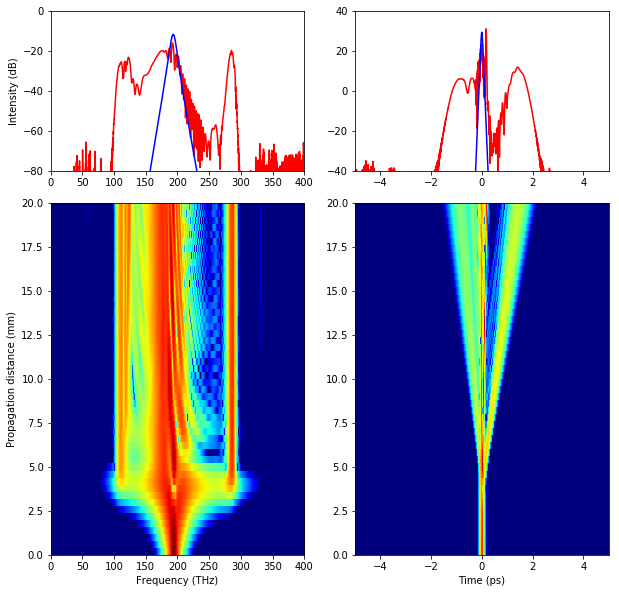

In [6]:
F = pulse.W_mks / (2 * np.pi) * 1e-12 # convert to THz

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y = y * 1e3 # convert distance to mm


# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


ax0.plot(F[F > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps,zT[-1], color='r')

ax0.plot(F[F > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 60.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax0.set_ylabel('Intensity (dB)')

ax2.set_xlabel('Frequency (THz)')
ax3.set_xlabel('Time (ps)')

ax2.set_ylabel('Propagation distance (mm)')

ax2.set_xlim(0,400)

ax0.set_ylim(-80,0)
ax1.set_ylim(-40,40)

plt.show()